In [1]:
import glob
import pandas as pd
import pyinform
import pprint
import time
import multiprocessing
import os
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
DATA_FILE_DIRECTORY: str = 'C:/STUFF/RESEARCH/TENet/DATA'
MINIMUM_POSTS = 10
FREQUENCY = 'D'

In [3]:
def read_data(data_directory):
    data_files = glob.glob(data_directory)
    print(data_files)
    df_list = []
    for idx, file in enumerate(data_files):
        print(f"Reading {idx + 1} of {len(data_files)} files.\nFile name: {file}")
        df = pd.read_csv(data_files[0], skiprows=6, parse_dates=['Date'])
        df = df[['Date', 'Hashtags', 'Twitter Author ID', 'Author', 'Url']]
        df = df.rename(columns={'Twitter Author ID': 'AuthorID'})
        df_list.append(df)
    return pd.concat(df_list).drop_duplicates()

In [4]:
def find_hashtag(hashtag_list_str, target_hashtags):
    if type(hashtag_list_str) != str:
        return None
    hashtag_list = hashtag_list_str.split(", ")
    print(hashtag_list)
    target_flags = [(lfh in hashtag_list) for lfh in target_hashtags]
    print(target_flags)
    
find_hashtag("#abc, #bbc, #foo, #cool", ['#abc', '#bbc'])

['#abc', '#bbc', '#foo', '#cool']
[True, True]


## Read data

In [5]:
task_start_time = time.time()

# Read all files and populate the global variables
all_data_df = read_data(os.path.join(DATA_FILE_DIRECTORY, "*.csv*"))
start_date = all_data_df['Date'].dt.date.min()
end_date = all_data_df['Date'].dt.date.max()

print(f"Data available from {start_date} to {end_date}")

# add Hashtag column
all_data_df['Hashtag'] = all_data_df.Hashtags.apply(
    lambda x: '#wildfire' if ((type(x) != str) or ('#wildfire' in x.split(", "))) else '#infinitychallenge')
all_data_df.drop(columns=["Hashtags"], inplace=True)
print(all_data_df.head())

print(f"{time.time() - task_start_time} seconds spent on calculating activity.")

['C:/STUFF/RESEARCH/TENet/DATA\\2033703822_TheThreeTopics.csv.zip']
Reading 1 of 1 files.
File name: C:/STUFF/RESEARCH/TENet/DATA\2033703822_TheThreeTopics.csv.zip
Data available from 2021-11-30 to 2022-03-01
                 Date    AuthorID           Author  \
0 2022-03-01 23:46:23  2498932848  berkeleyforests   
1 2022-03-01 23:15:13  3214604043       LarimerOEM   
2 2022-03-01 23:08:47    33319260       joanacasey   
3 2022-03-01 22:53:28  3437976809     RobMooreNRDC   
4 2022-03-01 22:49:30   227400774      ForestryUSA   

                                                 Url    Hashtag  
0  http://twitter.com/berkeleyforests/statuses/14...  #wildfire  
1  http://twitter.com/LarimerOEM/statuses/1498799...  #wildfire  
2  http://twitter.com/joanacasey/statuses/1498797...  #wildfire  
3  http://twitter.com/RobMooreNRDC/statuses/14987...  #wildfire  
4  http://twitter.com/ForestryUSA/statuses/149879...  #wildfire  
0.3219435214996338 seconds spent on calculating activity.


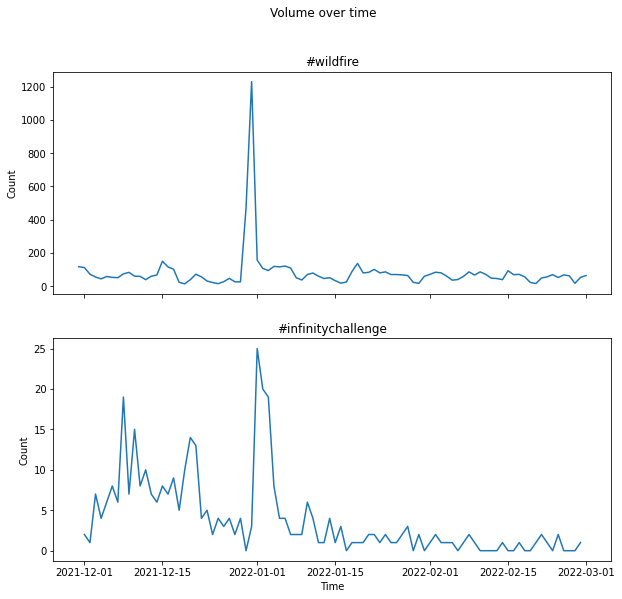

In [6]:
fig, axs = plt.subplots(2,sharex=True,figsize=(10, 9))

axs[0].plot(all_data_df[all_data_df.Hashtag == '#wildfire'].set_index('Date').resample('D').count().iloc[:,0])
axs[0].set_title("#wildfire")
axs[0].set_ylabel("Count")

axs[1].plot(all_data_df[all_data_df.Hashtag == '#infinitychallenge'].set_index('Date').resample('D').count().iloc[:,0])
axs[1].set_title("#infinitychallenge")
axs[1].set_ylabel("Count")

plt.suptitle("Volume over time")
plt.xlabel("Time")
plt.show()



In [32]:
print(all_data_df['Date'].dt.date.min())
d_t = pd.DatetimeIndex(pd.date_range(start=datetime.datetime(2021,12,1,0,0,0), end=datetime.datetime(2021,12,31,23,59,59), freq='12H'))
print(len(d_t))
d_t

2021-11-30
62


DatetimeIndex(['2021-12-01 00:00:00', '2021-12-01 12:00:00',
               '2021-12-02 00:00:00', '2021-12-02 12:00:00',
               '2021-12-03 00:00:00', '2021-12-03 12:00:00',
               '2021-12-04 00:00:00', '2021-12-04 12:00:00',
               '2021-12-05 00:00:00', '2021-12-05 12:00:00',
               '2021-12-06 00:00:00', '2021-12-06 12:00:00',
               '2021-12-07 00:00:00', '2021-12-07 12:00:00',
               '2021-12-08 00:00:00', '2021-12-08 12:00:00',
               '2021-12-09 00:00:00', '2021-12-09 12:00:00',
               '2021-12-10 00:00:00', '2021-12-10 12:00:00',
               '2021-12-11 00:00:00', '2021-12-11 12:00:00',
               '2021-12-12 00:00:00', '2021-12-12 12:00:00',
               '2021-12-13 00:00:00', '2021-12-13 12:00:00',
               '2021-12-14 00:00:00', '2021-12-14 12:00:00',
               '2021-12-15 00:00:00', '2021-12-15 12:00:00',
               '2021-12-16 00:00:00', '2021-12-16 12:00:00',
               '2021-12-

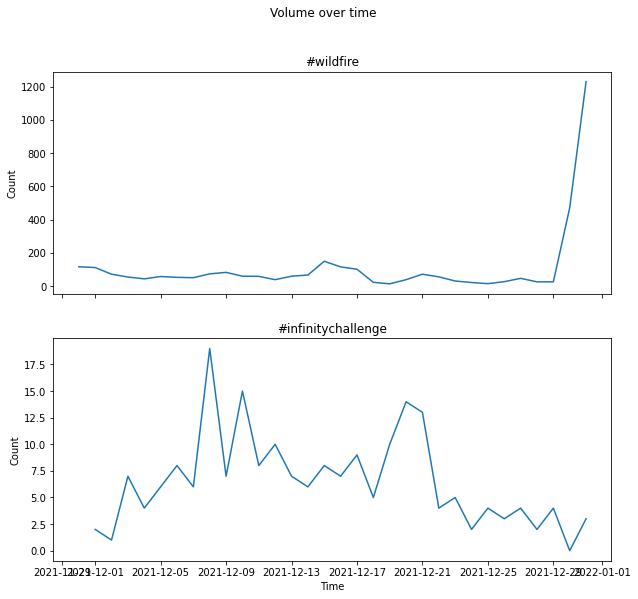

In [34]:
train_data_df = all_data_df[all_data_df['Date'] < datetime.datetime(2022,1,1)]
fig, axs = plt.subplots(2,sharex=True,figsize=(10, 9))

axs[0].plot(train_data_df[train_data_df.Hashtag == '#wildfire'].set_index('Date').resample('D').count().iloc[:,0])
axs[0].set_title("#wildfire")
axs[0].set_ylabel("Count")

axs[1].plot(train_data_df[train_data_df.Hashtag == '#infinitychallenge'].set_index('Date').resample('D').count().iloc[:,0])
axs[1].set_title("#infinitychallenge")
axs[1].set_ylabel("Count")

plt.suptitle("Volume over time")
plt.xlabel("Time")
plt.show()

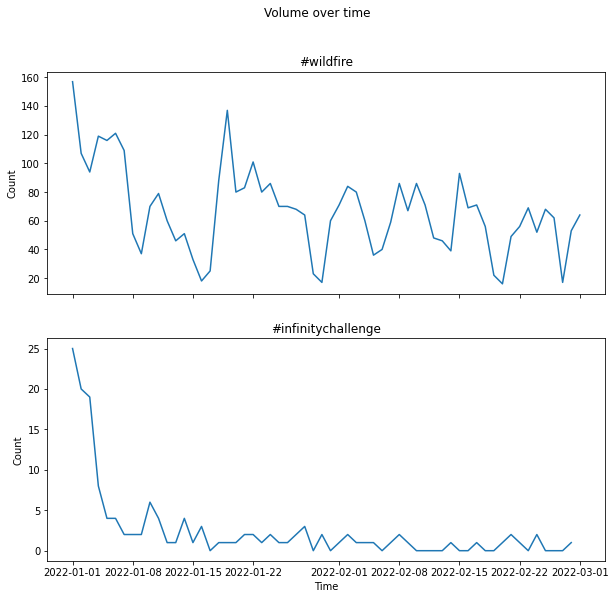

In [35]:
test_data_df = all_data_df[datetime.datetime(2022,1,1) < all_data_df['Date']]
fig, axs = plt.subplots(2,sharex=True,figsize=(10, 9))

axs[0].plot(test_data_df[test_data_df.Hashtag == '#wildfire'].set_index('Date').resample('D').count().iloc[:,0])
axs[0].set_title("#wildfire")
axs[0].set_ylabel("Count")

axs[1].plot(test_data_df[test_data_df.Hashtag == '#infinitychallenge'].set_index('Date').resample('D').count().iloc[:,0])
axs[1].set_title("#infinitychallenge")
axs[1].set_ylabel("Count")

plt.suptitle("Volume over time")
plt.xlabel("Time")
plt.show()

In [47]:
test_authors_wf = list(test_data_df[test_data_df.Hashtag == '#wildfire'].AuthorID.unique())
train_authors_wf = list(train_data_df[train_data_df.Hashtag == '#wildfire'].AuthorID.unique())
set(test_authors_wf).intersection(train_authors_wf)

{823736,
 12807482,
 12837932,
 13989852,
 14136114,
 14328161,
 14438014,
 14464919,
 14603016,
 14885540,
 14957366,
 15831289,
 16121795,
 16309969,
 16439077,
 16936434,
 17146195,
 17146256,
 17434395,
 17972127,
 18006842,
 18049298,
 18106904,
 18454808,
 18487522,
 18657835,
 18799695,
 19040480,
 19215993,
 19401084,
 19852608,
 20207761,
 20295438,
 20453796,
 22568654,
 22653760,
 23026561,
 23550121,
 24294856,
 24493890,
 25144145,
 25393191,
 27011922,
 29073978,
 29540950,
 31050510,
 31369265,
 33345091,
 33639779,
 36736490,
 38757024,
 38833974,
 43053129,
 43369337,
 43808144,
 44818932,
 44915639,
 47392306,
 48817182,
 49091628,
 50361094,
 51176565,
 51824585,
 52099553,
 53669645,
 54945432,
 54959494,
 58658349,
 62605503,
 64786050,
 68814343,
 72575785,
 74912769,
 81147404,
 83664766,
 85196590,
 85641096,
 88222692,
 90982474,
 93094812,
 95418595,
 98201361,
 99530254,
 103493067,
 104262458,
 110838368,
 118611326,
 120969408,
 123768410,
 123951004,
 1251

In [46]:
test_authors_ic = list(test_data_df[test_data_df.Hashtag == '#infinitychallenge'].AuthorID.unique())
train_authors_ic = list(train_data_df[train_data_df.Hashtag == '#infinitychallenge'].AuthorID.unique())
set(test_authors_ic).intersection(train_authors_ic)

{2960142736,
 974067803580915712,
 1073212667723161600,
 1272469203598090240,
 1313639909517795328}

In [7]:
# find high activity authors

task_start_time = time.time()

author_to_num_mentions_dict = all_data_df['AuthorID'].value_counts().to_dict()
high_activity_authors = [a for a in author_to_num_mentions_dict if author_to_num_mentions_dict[a] > MINIMUM_POSTS]
indexed_high_activity_authors = [(i, j) for i, j in enumerate(high_activity_authors)]

print(high_activity_authors)

print(f"{time.time() - task_start_time} seconds spent on calculating activity.")

[58658349, 3111226033, 3301926908, 128128069, 20207761, 884130463878529024, 154902138, 1358718719577489410, 239666710, 1104740466, 763336831295328256, 25144145, 18454808, 250402748, 314024592, 22653760, 1403131600653590528, 14957366, 1136055528273133569, 179261808, 1318962022143254530, 125177569, 1877444256, 1148457028920078336, 262675787, 16309969, 958321766, 48817182, 126075164, 3245582817, 922902086194311168, 400472437, 1163887880, 484265155, 151543424, 326890702, 38833974, 50361094, 74912769, 20295438, 20453796, 1471594463722041344, 587575999, 170554164, 4784417526, 2493306794, 1908515251, 852163986644717568, 1327793130, 81147404, 306243059, 2598357146, 1298648659362373632, 19215993, 2414195305, 910767907377889281, 1089306632016654336, 12837932, 305818642, 2591349990]
0.00496673583984375 seconds spent on calculating activity.


In [17]:
def generate_timeseries_index(start_time, end_time, frequency):
    """
    Generates an index for a timeseries for a given start time, end time, and a time interval (frequency).
    :param start_time: start time of timeseries
    :type start_time: datetime
    :param end_time: end time of timeseries
    :type end_time: datetime
    :param frequency: Frequency value as a string. e.g. "12H", "D", "30min"
    :type frequency: str
    :return:
    :rtype:
    """
    return pd.DatetimeIndex(pd.date_range(start=start_time, end=end_time, freq=frequency))

def multiprocess_run_calculate_author_values(author_list, author_id_to_num_mentions_dict, all_data, time_index, frequency):
    """
    Calculates the author node and timeseries data for each author in the given author_list using Multiprocessing Pools.
    Results contain an ordered list of results which represent the data for each respective author in the order of
     author_list parameter. Each node will correspond to an author_id.
    :param author_list: list of author_id values for which we calculate nodes.
    :type author_list: list
    :param author_id_to_num_mentions_dict: a dictionary that contains number of mentions value for each author_id
    :type author_id_to_num_mentions_dict: dict
    :param all_data: pandas dataframe that contains all the data for processing
    :type all_data: pd.Dataframe
    :param time_index: a pandas series that will be used as the index for resampling the data
    :type time_index: pd.Series
    :return: a list where each element represents a tuple (of length = 2) for corresponding author_id.
    Each element is a tuple of two items. 0th item is the node info that contains
     [author_id, author_username, number of mentions]. 1st item is the timeseries values as a binary list.
    For more information check the calculate_author_values function that is being called by this function.
    :rtype: list
    """
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        results = p.starmap(calculate_author_values,
                            [(author, author_id_to_num_mentions_dict[author], all_data, time_index, frequency) for author in
                             author_list])
    return results

def calculate_author_values(author_id, num_mentions, all_data, time_index, frequency):
    """
    Returns the Node information and generated timeseries of the Author
    Reads the data from ALL_DATA global variable which must have been populated before invoking this function.
    :param time_index: The timeseries index for given frequency
    :type time_index: pd.DatetimeIndex
    :param all_data: Dataframe of all events
    :type all_data: pd.Dataframe
    :param num_mentions:
    :type num_mentions: int
    :param author_id: AuthorID
    :type author_id: str
    :return: A tuple of two items. 0th item is the node info that contains [author_id, author, number of mentions]. 1st
     item is the timeseries values as a binary list.
    :rtype: tuple
    """
    author_id_events = all_data[all_data['AuthorID'] == author_id]
    return ([author_id, author_id_events['Author'].iloc[0], num_mentions],
            generate_sampled_binary_timeseries(author_id_events.set_index('Date'), time_index, frequency).values)


In [ ]:
# get start date and end date and reate time index for the timeseries
start_date = all_data_df['Date'].dt.date.min()
end_date = all_data_df['Date'].dt.date.max() + datetime.timedelta(days=1)
print(f"Data available from {start_date} to {end_date}")
time_index_series = generate_timeseries_index(start_date, end_date, FREQUENCY)


# calculate author data
results = multiprocess_run_calculate_author_values(high_activity_authors, author_to_num_mentions_dict, all_data_df,
                                                   time_index_series, FREQUENCY)
time_series_list = [r[1] for r in results]
node_list = [r[0] for r in results]
del results

print(f"{time.time() - task_start_time} seconds spent on resampling the timeseries and setting up node data")
task_start_time = time.time()

Data available from 2021-11-30 to 2022-03-02


In [9]:






print("Time series list: ", len(time_series_list))
print("Node list: ", len(node_list))

# generate node list file for Gephi
node_list_df = pd.DataFrame(node_list, columns=['Id', 'Label', 'Count'])
node_list_df.to_csv('nodes.csv', index=False)
del node_list_df
del node_list

print(f"{time.time() - task_start_time} seconds spent on writing node list to file.")
task_start_time = time.time()

# the te values calculated for enumerated authors
src_tgt_te = multiprocess_run_calculate_te_edge_list(indexed_high_activity_authors, time_series_list)

print(f"{time.time() - task_start_time} seconds spent on calculating transfer entropy.")
task_start_time = time.time()

# generate edge list file for Gephi
edge_list_df = pd.DataFrame(src_tgt_te, columns=['Source', 'Target', 'TE'])
print(edge_list_df)
edge_list_df['Weight'] = edge_list_df['TE'].apply(lambda x: 1 if x > 0.05 else 0)
max_te = edge_list_df['TE'].max()
edge_list_df['Normalized'] = edge_list_df['TE'].apply(lambda x: x / max_te)
print(edge_list_df)
edge_list_df.to_csv('edges.csv', index=False)

print(f"{time.time() - task_start_time} seconds spent on writing edge list to file.")
task_start_time = time.time()

NameError: name 'time_series_list' is not defined